In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineG

In [3]:
# Install Required Libraries:

!pip install -q \
  torch torchvision \
  transformers==4.50.3 \
  datasets==3.5.0 \
  evaluate==0.4.3 \
  matplotlib \
  pillow==11.1.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 124.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [12]:
# 2. Imports and Setup

from PIL import Image
from pathlib import Path
import random
import torch
import numpy as np
import evaluate
import logging
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from transformers import (
    ViTImageProcessor,
    ViTForImageClassification,
    TrainingArguments,
    Trainer
)

from google.colab import drive, files
import os

# Enable logging
logging.basicConfig(
    filename="training_log.txt",
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

In [13]:
# 3. Download & Unzip Dataset

!pip install -q gdown

import gdown
import zipfile

# Download from Google Drive
file_id = "1ZTAqu1Idkpn6TnYQlfSYSzXUTiHGwicw"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="datasetTWO.zip", quiet=False)

# Unzip dataset
with zipfile.ZipFile("datasetTWO.zip", 'r') as zip_ref:
    zip_ref.extractall("datasetTWO")


Downloading...
From (original): https://drive.google.com/uc?id=1ZTAqu1Idkpn6TnYQlfSYSzXUTiHGwicw
From (redirected): https://drive.google.com/uc?id=1ZTAqu1Idkpn6TnYQlfSYSzXUTiHGwicw&confirm=t&uuid=58866087-32ea-4dff-8321-3c34d1d8f437
To: /content/datasetTWO.zip
100%|██████████| 291M/291M [00:05<00:00, 54.1MB/s]


In [2]:
from pathlib import Path
from PIL import Image
import random

def load_dataset_split(split_folder, max_per_class=200):
    data = []
    for label_name, label in [("real", 0), ("fake", 1)]:
        folder_path = Path(split_folder) / label_name
        image_paths = list(folder_path.rglob("*"))
        image_paths = [p for p in image_paths if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp", ".webp"]]
        !ls
        print(image_paths)
        selected_paths = random.sample(image_paths, min(max_per_class, len(image_paths)))

        for p in selected_paths:
            try:
                img = Image.open(p).convert("RGB")
                data.append({"image": img, "label": label})
            except Exception as e:
                print(f"Could not load image {p}: {e}")
    return data

train_data = load_dataset_split("datasetTWO/GAN-10k/train", max_per_class=3500)
val_data   = load_dataset_split("datasetTWO/GAN-10k/valid", max_per_class=750)
test_data  = load_dataset_split("datasetTWO/GAN-10k/test", max_per_class=750)

from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    "train": Dataset.from_list(train_data),
    "validation": Dataset.from_list(val_data),
    "test": Dataset.from_list(test_data),
})


datasetTWO	loss_curve.png	vit-deepfake-finetune
datasetTWO.zip	sample_data	vit-my-winning-run
[PosixPath('datasetTWO/GAN-10k/train/real/27137.jpg'), PosixPath('datasetTWO/GAN-10k/train/real/21460.jpg'), PosixPath('datasetTWO/GAN-10k/train/real/33778.jpg'), PosixPath('datasetTWO/GAN-10k/train/real/60586.jpg'), PosixPath('datasetTWO/GAN-10k/train/real/47734.jpg'), PosixPath('datasetTWO/GAN-10k/train/real/44074.jpg'), PosixPath('datasetTWO/GAN-10k/train/real/12521.jpg'), PosixPath('datasetTWO/GAN-10k/train/real/00150.jpg'), PosixPath('datasetTWO/GAN-10k/train/real/04396.jpg'), PosixPath('datasetTWO/GAN-10k/train/real/13040.jpg'), PosixPath('datasetTWO/GAN-10k/train/real/37811.jpg'), PosixPath('datasetTWO/GAN-10k/train/real/51032.jpg'), PosixPath('datasetTWO/GAN-10k/train/real/44386.jpg'), PosixPath('datasetTWO/GAN-10k/train/real/18973.jpg'), PosixPath('datasetTWO/GAN-10k/train/real/55804.jpg'), PosixPath('datasetTWO/GAN-10k/train/real/68394.jpg'), PosixPath('datasetTWO/GAN-10k/train/real/

In [3]:
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
import numpy as np

checkpoint_path = "./vit-deepfake-finetune/best_model"
image_processor = ViTImageProcessor.from_pretrained(checkpoint_path)
model = ViTForImageClassification.from_pretrained(checkpoint_path)

def transform(example_batch):
    inputs = image_processor([img for img in example_batch["image"]], return_tensors="pt")
    inputs["labels"] = example_batch["label"]
    return inputs

dataset["train"] = dataset["train"].with_transform(transform)
dataset["validation"] = dataset["validation"].with_transform(transform)

def collate_fn(batch):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "labels": torch.tensor([x["labels"] for x in batch])
    }

training_args = TrainingArguments(
   output_dir="./vit-deepfake-second-finetune",
    per_device_train_batch_size=24,
    gradient_accumulation_steps=1,
    fp16=True,
    num_train_epochs=10,
    learning_rate=3e-5,
    weight_decay=0.02,
    warmup_ratio=0.08,
    lr_scheduler_type="cosine",
    label_smoothing_factor=0.05,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True
)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted")
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=image_processor,
    data_collator=collate_fn,
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-3-42007ebef900>:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [4]:
import torch

if torch.cuda.is_available():
    print("GPU is active:", torch.cuda.get_device_name(0))
else:
    print("GPU not available — double check runtime settings.")



GPU is active: Tesla T4


In [5]:


trainer.train()

model.save_pretrained("./vit-deepfake-second-finetune/best_model")
image_processor.save_pretrained("./vit-deepfake-second-finetune/best_model")


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.307600,0.637518,0.746667,0.729488,0.830659,0.746667
2,0.234600,0.171861,0.974000,0.973987,0.974919,0.974000
3,0.121300,0.159418,0.980000,0.979999,0.980055,0.980000
4,0.129300,0.183728,0.972000,0.971982,0.973215,0.972000
5,0.117000,0.149666,0.987333,0.987333,0.987334,0.987333
6,0.117100,0.144028,0.988667,0.988667,0.988688,0.988667
7,0.117000,0.142418,0.988667,0.988667,0.988674,0.988667
8,0.116900,0.141993,0.989333,0.989333,0.989347,0.989333
9,0.116900,0.142127,0.989333,0.989333,0.989347,0.989333
10,0.116900,0.142127,0.989333,0.989333,0.989347,0.989333


['./vit-deepfake-second-finetune/best_model/preprocessor_config.json']

In [8]:
dataset["test"] = dataset["test"].with_transform(transform)
metrics = trainer.evaluate(eval_dataset=dataset["test"])
test_acc = metrics["eval_accuracy"]

print(f"Test Set Accuracy: {test_acc:.4f}")
print("=== Training Complete ===")
print("Test Set Accuracy:", test_acc)

Test Set Accuracy: 0.9920
=== Training Complete ===
Test Set Accuracy: 0.992


In [18]:
from datasets import Dataset, DatasetDict
from pathlib import Path
from PIL import Image
import random

def load_dataset_split(split_folder, max_per_class=200):
    data = []
    for label_name, label in [("real", 0), ("fake", 1)]:
        folder_path = Path(split_folder) / label_name
        image_paths = list(folder_path.rglob("*"))
        image_paths = [p for p in image_paths if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp", ".webp"]]
        print(f"Found {len(image_paths)} images in {folder_path}")

        selected_paths = random.sample(image_paths, min(max_per_class, len(image_paths)))

        for p in selected_paths:
            try:
                img = Image.open(p).convert("RGB")
                data.append({"image": img, "label": label})
            except Exception as e:
                print(f"Could not load image {p}: {e}")
    return data

# Load test data
test_data = load_dataset_split("datasetTWO/OpenForensics-10k/test", max_per_class=750)

# Create Hugging Face DatasetDict
dataset1 = DatasetDict({
    "test": Dataset.from_list(test_data),
})

# Apply transform (assume 'transform' is a callable defined earlier)
dataset1["test"] = dataset1["test"].with_transform(transform)

# Evaluate using a Hugging Face Trainer (assume 'trainer' is defined earlier)
metrics = trainer.evaluate(eval_dataset=dataset1["test"])
test_acc = metrics["eval_accuracy"]
print("Test Accuracy:", test_acc)


Found 750 images in datasetTWO/OpenForensics-10k/test/real
Found 750 images in datasetTWO/OpenForensics-10k/test/fake


Test Accuracy: 0.6113333333333333


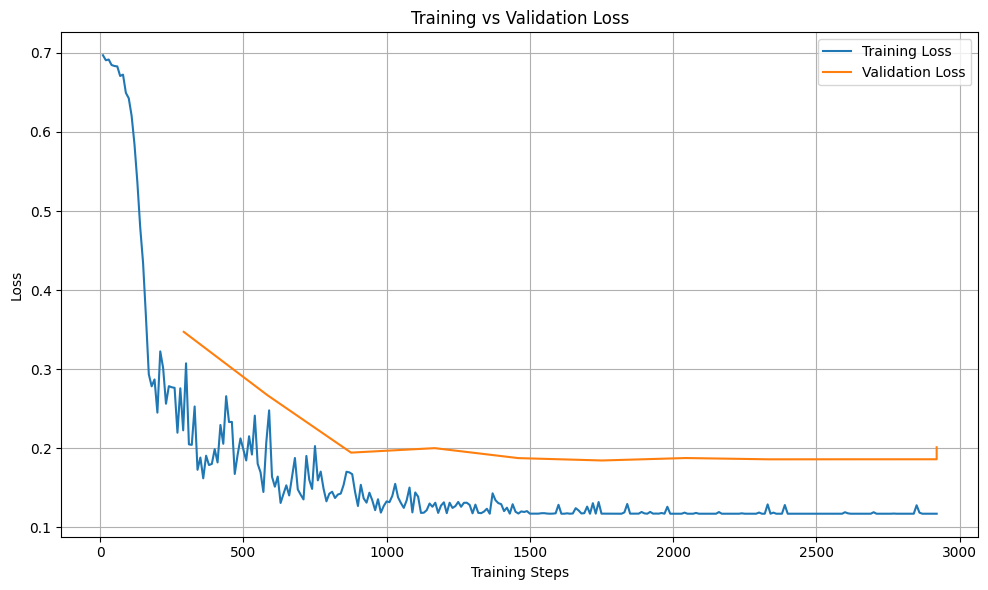

In [11]:
# 8. Plot Loss Curve

train_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log]
eval_loss = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
steps_train = [log["step"] for log in trainer.state.log_history if "loss" in log]
steps_eval = [log["step"] for log in trainer.state.log_history if "eval_loss" in log]

plt.figure(figsize=(10, 6))
plt.plot(steps_train, train_loss, label="Training Loss")
plt.plot(steps_eval, eval_loss, label="Validation Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve.png")
plt.show()